In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


from textblob import TextBlob 
from wordcloud import WordCloud 

import plotly.graph_objects as go

import json
import re 
import tweepy 
from tweepy import OAuthHandler 
from textblob import TextBlob 

import warnings
warnings.filterwarnings('ignore')

### Create Twitter Application
Need a twitter account in order to create a Twitter application.  We'll use Python code to interface with application to stream live tweets.<br>

In [2]:
with open('/Users/davidtorres/.secret/config_Mod_5.json') as file:
    json_data = json.load(file)

In [3]:
authenticate = tweepy.OAuthHandler(json_data['consumer_key'],json_data['consumer_secret_key'])
authenticate.set_access_token(json_data['access_token'], json_data['access_token_secret'])

In [26]:
api = tweepy.API(authenticate, wait_on_rate_limit= True)
#api = tweepy.API(authenticate, wait_on_rate_limit= True)
#api = tweepy.API(authenticate, wait_on_rate_limit= True)

## posts = api.user_timeline(screen_name='@pfizer', count=5, lang='en', tweet_mode='extended')

posts= api.search('Grindr')

In [27]:
for tweet in posts:
    print(tweet.text)

[17/4 10:56]: amigo
[17/4 10:58] Felipe Martins: Oii
[17/4 11:00]: jovem mamador no grindr é tu?
[17/4 11:00] Felip… https://t.co/xdRKNSsih7
@rtr97_ Sksksks as if I’d have the confidence to be on grindr even if I weren’t sitting here in my apt in Chicago 😂😂😂
Another ugly twitter gay being ugly to people on grindr for no reason pt. 24748 https://t.co/hdRbQb8yRu
RT @Sanforu1: Have downloaded weatherspoon app and Grindr app and going to get high @ findom
@antnyvlz yikes this is why I deleted Grindr when I worked at the gym people are awful (or creepy but yeah)
@gruuble @mtcorn97 @RVineshank I don’t think he meant “she” literally, and trans women use Grindr too :)
@Grindr Quiero q publiquen aki alguna foto mía pana me conoscscana alguien aserme novio
Ahi pueden ver el número del que anda estafando en AQP con mis fotos estando yo hace más de un año en Brasil. Puede… https://t.co/ynFRUaJUu5
Also I know they’re not dating bc the younger guy is on Grindr and he says he’s single and not in any 

In [22]:
def get_tweets(posts):
    tweet_list = []
    for twt in posts:
        tweet_list.append(twt._json)
    tweet_data = pd.DataFrame.from_records(tweet_list)#tweet_df = tweet_data[['created_at','full_text']]
    tweet_df = tweet_data[['created_at','full_text']]
    tweet_df['Date'] = pd.to_datetime(tweet_df['created_at'])
    tweet_df['Date'] = pd.to_datetime(tweet_df['Date'], format='%Y:%m:%d').dt.date
    tweet_df.set_index(["Date"], inplace = True) 
    tweet_df.drop('created_at',axis=1,inplace=True)
    return tweet_df

In [23]:
tweets_df = get_tweets(posts)
tweets_df

KeyError: "['full_text'] not in index"

In [7]:
#clean the text
def cleanTxt(text):
    text = re.sub(r'@[A-Za-z0-9]+','',text) #r-tells python that expression is a raw tring, once we find substitute fo empty string
  #get rid of any hashtag or number sign
    text = re.sub(r'#', '', text)
    text = re.sub(r'RT[\s]+','', text)  #retweets followed by 1 or more white spaces
    #remove the hyper link
    text = re.sub(r'https?:\/\/\S+','', text)      #may have 0 or 1 s character
    
    return text

In [8]:
#cleaning hte text
tweets_df['full_text'] = tweets_df['full_text'].apply(cleanTxt)

In [9]:
pd.set_option('display.max_rows', None)
tweets_df

,full_text
Date,
2021-04-16,Co-lead of our Multicultural Health Equity Col...
2021-04-16,’s first-ever industry-wide principles on dive...
2021-04-16,: Ensuring diversity of volunteers in clinical...
2021-04-15,"Congratulations to , our Chief Development Off..."
2021-04-15,Join us today for a conversation about efforts...


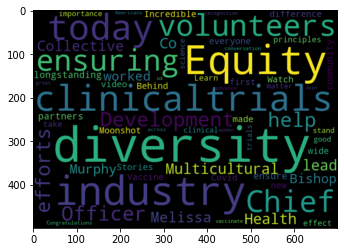

In [10]:
allWords = ' '.join([twts for twts in tweets_df['full_text']])
wordCloud = WordCloud(width=700, height=500, random_state=21,max_font_size=110).generate(allWords)
plt.imshow(wordCloud,interpolation='bilinear')

In [11]:
#get subjectivity (how subjective or opinated text is)and pularity (how postive or negative text is)
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

In [12]:
#create 2 new columns
tweets_df['Subjectivity'] = tweets_df['full_text'].apply(getSubjectivity)
tweets_df['Polarity'] = tweets_df['full_text'].apply(getPolarity)

In [13]:
def getAnalysis(score):
    #function to calculate the negative, neutral and positve analysis
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [14]:
#polarity is the score and going to apply the  function
tweets_df['Analysis'] = tweets_df['Polarity'].apply(getAnalysis)

In [15]:
tweets_df

,full_text,Subjectivity,Polarity,Analysis
Date,,,,
2021-04-16,Co-lead of our Multicultural Health Equity Col...,0.684848,0.212121,Positive
2021-04-16,’s first-ever industry-wide principles on dive...,0.500000,0.500000,Positive
2021-04-16,: Ensuring diversity of volunteers in clinical...,0.600000,0.700000,Positive
2021-04-15,"Congratulations to , our Chief Development Off...",0.750000,0.800000,Positive
2021-04-15,Join us today for a conversation about efforts...,0.000000,0.000000,Neutral


In [16]:
tweets_df.shape

(5, 4)